In [1]:
import time
import numpy as np

from matplotlib import pyplot as plt
# from matplotlib import patches

from sklearn.datasets import make_classification, load_breast_cancer, load_iris
from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

In [2]:
class DiscriminantLineaire:
    """Linear discriminant with gradient descent.

    Parameters
    ----------
    eta : float
        Learning rate
    epsilon : float
        Stop variable, if Previous_Error - Error < epsilon then stop learning
    max_iter : int
        Maximum possible number of learning iterations

    Attributes
    ----------
    eta
    epsilon
    max_iter
    w weights of the discriminant function
    """

    def __init__(self, eta=2e-2, epsilon=1e-6, max_iter=1000):
        # Cette fonction est déjà  codée pour vous, vous n'avez qu'à  utiliser
        # les variables membres qu'elle définit dans les autres fonctions de
        # cette classe.
        self.eta = eta
        self.epsilon = epsilon
        self.max_iter = max_iter

    def fit(self, X, y):
        """Compute the weights of the linear discriminant and put them in
        self.w.

            Parameters
            ----------
            X : Array (will be casted in numpy.array)
                Features to learn from.
            y : Array (will be casted in numpy.array)
                target values for X (will be transformed into -1, 1 values)

            Returns
            -------
            None
                Nothing but will compute and store the weights in self.w

            Raises
            -------
            Exception
                set of target y need to be {0,1} or {-1,1} else the computation
                will not converge
            """

        if set(y) == {0, 1}:
            y = (y * 2) - 1
        elif set(y) != {-1, 1}:
            raise Exception("The target must be {0,1} or {-1,1}")
        # Implémentez la fonction d'entraînement du classifieur, selon
        # les équations que vous avez développées dans votre rapport.

        # On initialise les poids aléatoirement
        w = np.random.rand(X.shape[1] + 1)
        # Je prend w[0] = w0 et w[1:] tout le reste des poids
        w = np.array(w)

        # TODO Q2B
        # Vous devez ici implémenter l'entraînement.
        # Celui-ci devrait être contenu dans la boucle suivante, qui se répète
        # self.max_iter fois
        # Vous êtes libres d'utiliser les noms de variable de votre choix, sauf
        # pour les poids qui doivent être contenus dans la variable w définie
        # plus haut
        Err_prec = 1e10
        for i in range(self.max_iter):
            ind_mal_classe = []
            deltawi = np.zeros(len(w) - 1)
            deltaw0 = np.zeros(1)
            w = w / np.linalg.norm(w)  # Afin d'éviter un overflow
            for j in range(len(y)):
                hxw = np.dot(w[1:], X[j]) + w[0]
                if (hxw * y[j]) <= 0:
                    ind_mal_classe.append(j)
                    num = (y[j] - hxw) / np.linalg.norm(X[j])**2
                    deltawi += num * X[j]
                    deltaw0 += num

            normeX = np.linalg.norm(X[ind_mal_classe])**2
            numX = np.array(
                [(y[i] - np.dot(w[1:], X[i]) + w[0]) / normeX
                 for i in ind_mal_classe])

            Err = 0.5 * sum(numX**2 / normeX)
            w[0] += self.eta * deltaw0
            w[1:] += self.eta * deltawi

            if (Err_prec - Err) < self.epsilon:
                print("Les poids ont convergés en : ", i, " itérations")
                break
            else:
                Err_prec = Err

            # à ce stade, la variable w devrait contenir les poids entraînés
            # On les copie dans une variable membre pour les conserver
        self.w = w

        return None

    def predict(self, X):
        """Predict the class on a trained model (!! need to fit() first !!)

        Parameters
        ----------
        X : Array
            Features to learn from.

        Returns
        -------
        array of size len(X)
            -1 or 1 for each data class
            (Linear discriminant only perfmorms a double class analysis)
        """
        # TODO Q2B
        # Implémentez la fonction de prédiction
        # Vous pouvez supposer que fit() a préalablement été exécuté
        return [np.sign(np.dot(self.w[1:], X[i]) + self.w[0]).astype(int)
                for i in range(len(X))]

        # Au lieu de sign...
        # np.array([1 if np.dot(self.w[1:], x) + self.w[0] >= 0
        #           else -1 for x in X])

    def score(self, X, y):
        """Compute the score of the prediction on X with respect to y targets

        Parameters
        ----------
        X : Array
            Features to score from.
        y : Array
            target values for X (will be transformed into -1, 1 values)

        Returns
        -------
        float
            Accuracy (number of good answer)

        Raises
        -------
        Exception
            set of target y need to be {0,1} or {-1,1} because the model was
            train and will score like that
        """
        if set(y) == {0, 1}:
            y = (y * 2) - 1
        elif set(y) != {-1, 1}:
            raise Exception("The target must be {0,1} or {-1,1}")
        # TODO Q2B
        # Implémentez la fonction retournant le score (précision / accuracy)
        # du classifieur sur les données reçues en argument.
        # Vous pouvez supposer que fit() a préalablement été exécuté
        # Indice : réutiliser votre implémentation de predict() réduit de
        # beaucoup la taille de cette fonction!

        # Question 2B
        # Implémentation du classifieur un contre tous utilisant le
        # discriminant linéaire défini plus haut
        return sum([self.predict(X)[i] == y[i]
                    for i in range(len(y))]) / len(y)


class ClassifieurUnContreTous:
    """Compute a multi-class classification with a one against all method.

    Parameters
    ----------
    n_classes : into
        number of target classes.
    method : string
        Choice for the one against all method, can be argmax or
        posval (positive value). The second one implies ambiguous regions.
    **kwargs : dict
        list of arguments for the DiscriminantLineaire class.

    Attributes
    ----------
    estimators :list of n_classes DiscriminantLineaire Objects
        Used to to a two class computation, each class against the rest of all.
    method
    n_classes
    """

    def __init__(self, n_classes, method='argmax', **kwargs):
        # Cette fonction est déjà  codée pour vous, vous n'avez qu'à  utiliser
        # les variables membres qu'elle définit dans les autres fonctions de
        # cette classe.
        self.method = method
        self.n_classes = n_classes
        self.estimators = [DiscriminantLineaire(
            **kwargs) for c in range(n_classes)]

    def fit(self, X, y):
        """Fit each of the n_classes classifier against all the rest of the
        datas. (Ex for 3 class : class 1 vs rest(2,3) class2 vs rest(1,3)
        class 3 vs rest(1,2)).

        Parameters
        ----------
        X : Array
            Features to score from.
        y : Array
            target values for X

        Returns
        -------
        None
            compute the weights of the each DiscriminantLineaire class and put
            them into the class variable w.
        """
        # TODO Q2C
        # Implémentez ici une approche un contre tous, oà¹ chaque classifieur
        # (contenu dans self.estimators) est entraîné à  distinguer une seule
        # classe versus toutes les autres
        for i in range(self.n_classes):
            target = y.copy()
            target[np.where(target == i)] = -1
            target[np.where(target != -1)] = 1
            # target = (target*2)-1 pour mettre entre -1 et 1
            # mais déjà implémenté dans le fit de Disciminant linéraire
            self.estimators[i].fit(X, target)
        return None

    def predict(self, X):
        """Predict the class on a trained model (!! need to fit() first !!).

        Parameters
        ----------
        X : Array
            Features to predict from.

        Returns
        -------
        numpy.array
            all the classes of each elements of X. Can be from 0 to n_classes
            in case of argmax or from 0 to n_classes plus an ambiguous class
            for the posval method.
        """
        # TODO Q2C
        # Implémentez ici la prédiction utilisant l'approche un contre tous
        # Vous pouvez supposer que fit() a préalablement été exécuté

        if self.method == 'argmax':
            classes = []
            for i in range(len(X)):
                Hall = -np.array([np.dot(est.w[1:], X[i]) + est.w[0]
                                  for est in self.estimators])

                classes.append(np.argmax(Hall))
            return classes

        elif self.method == 'posval':
            classes = []
            for i in range(len(X)):
                Hall = -np.array([np.dot(est.w[1:], X[i]) + est.w[0]
                                  for est in self.estimators])
                classes.append(np.argmax(Hall) if sum(Hall >= 0) == 1
                               else self.n_classes + 1)
            # pour faire le produit de tout les elements d'une liste
            # reduce(lambda x, y: x*y, Hall)
            # np.prod(np.array(Hall))
            return classes

    def score(self, X, y):
        """Compute the score of the prediction on X with respect to y labels.

        Parameters
        ----------
        X : Array
            Features to score from.
        y : Array
            target values for X
        Returns
        -------
        float
            Accuracy : number of good classificated values.
        """
        # TODO Q2C
        # Implémentez ici le calcul du score utilisant l'approche un contre
        # tous. Ce score correspond à  la précision (accuracy) moyenne.
        # Vous pouvez supposer que fit() a préalablement été exécuté

        if self.method == "posval":
            somme = 0
            for i in range(len(X)):
                pred = self.predict([X[i]])[0]
                if 0 <= pred <= self.n_classes:
                    somme += pred
            return somme / len(y)

        elif self.method == "argmax":
            return sum([self.predict(X)[i] == y[i]
                        for i in range(len(y))]) / len(y)




Les poids ont convergés en :  2  itérations
Score 2 Classes:  0.98


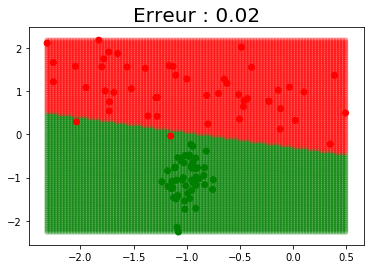

In [3]:
# #############################################################################
# #############################################################################
# ###################            MAIN                   #######################
# #############################################################################
# #############################################################################


# #########################################################################
# #########################################################################
# ###################          Q°2C  2 classes     ########################
# #########################################################################
# #########################################################################

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1)
if set(y) == {0, 1}:
    y = (y * 2) - 1
elif set(y) != {-1, 1}:
    raise Exception("The target must be {0,1} or {-1,1}")

# Création de la grille pour la prédiciton des zones.
pas = 100
x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), pas)
x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), pas)
absc, ordon = np.meshgrid(x1, x2)

clf = DiscriminantLineaire()
clf.fit(X, y)

print("Score 2 Classes: ", clf.score(X, y))
fig, sfig = plt.subplots(1, 1, sharex=True, sharey=True)

colors = ["bgr"[i] for i in clf.predict(
    np.c_[absc.ravel(), ordon.ravel()])]

# sfig.contourf(absc, ordon, colors) Pour tracer une frontière entre classe

sfig.scatter(absc, ordon, alpha=0.3, s=20, c=colors)
sfig.scatter(X[:, 0], X[:, 1], c=["bgr"[i] for i in y])
sfig.set_title("Erreur : " + str("%.2f" % round(1 - clf.score(X, y), 2)),
               fontsize=20)

plt.show()


Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Score 3 classes :  0.8


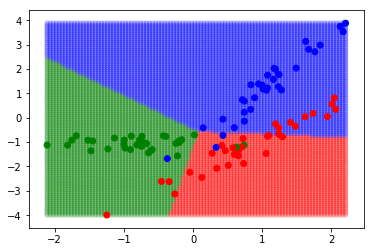

In [4]:

# #########################################################################
# #########################################################################
# ###################          Q°2C  3 classes     ########################
# #########################################################################
# #########################################################################
# 3 classes
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, n_classes=3)
# TODO Q2C
# Testez la performance du discriminant linéaire pour le problème
# à  trois classes, et tracez les régions de décision

# Création de la grille pour la prédiciton des zones.
pas = 100
x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), pas)
x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), pas)
absc, ordon = np.meshgrid(x1, x2)

clf = ClassifieurUnContreTous(
    n_classes=3, method='argmax', eta=2e-2, epsilon=1e-6)
clf.fit(X, y)
print("Score 3 classes : ", clf.score(X, y))

fig, sfig = plt.subplots(1, 1, sharex=True, sharey=True)
colors = ["bgrcmykw"[i] for i in clf.predict(
    np.c_[absc.ravel(), ordon.ravel()])]
sfig.scatter(absc, ordon, alpha=0.2, s=20, c=colors)
sfig.scatter(X[:, 0], X[:, 1], c=["bgrcmykw"[i] for i in y])


plt.show()

In [5]:
# #########################################################################
# #########################################################################
# ###################          Q°2D     Cancer            #################
# #########################################################################
# #########################################################################
# Question 2D

# TODO Q2D
# Chargez les données "Breast cancer Wisconsin" et normalisez les de
# manière à  ce que leur minimum et maximum soient de 0 et 1
data = load_breast_cancer()
X, y = minmax_scale(data.data, feature_range=(0, 1)), data.target
print(len(X[0]))
# TODO Q2D
# Comparez les diverses approches demandées dans l'énoncé sur Breast Cancer
# Initialisez votre discriminant linéaire avec les paramètres suivants :
# DiscriminantLineaire(eta=1e-4, epsilon=1e-6, max_iter=10000)
# Pour les autres approches, conservez les valeurs par défaut
# N'oubliez pas que l'évaluation doit être faite par une validation
# croisée à  K=3 plis!

clfs = [DiscriminantLineaire(eta=1e-4, epsilon=1e-6, max_iter=100),
        LinearDiscriminantAnalysis(),
        Perceptron(),
        LogisticRegression()]

kf = KFold(n_splits=3, random_state=666, shuffle=True)
ErrorsTest = [0] * 4
ErrorsTrain = [0] * 4
for i in range(len(clfs)):
    avgErrorTest = 0
    avgErrorTrain = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clfs[i].fit(X_train, y_train)
        avgErrorTrain += 1 - clfs[i].score(X_train, y_train)
        avgErrorTest += 1 - clfs[i].score(X_test, y_test)
    ErrorsTest[i] = avgErrorTest / 3
    ErrorsTrain[i] = avgErrorTrain / 3

print("Erreurs cancer Train (Own, Linear, Perceptron, Logistic) :\n",
      ErrorsTrain)
print("Erreurs cancer Test (Own, Linear, Perceptron, Logistic) :\n",
      ErrorsTest)


30
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Erreurs cancer Train (Own, Linear, Perceptron, Logistic) :
 [0.37259176966162105, 0.03515252511225294, 0.04743322686663887, 0.033388881173911034]
Erreurs cancer Test (Own, Linear, Perceptron, Logistic) :
 [0.37261672700269194, 0.04218880534670011, 0.05982548965005104, 0.04218880534670011]


/home/pedrok/Programmes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [6]:
# #########################################################################
# #########################################################################
# ###################          Q°2D   IRIS                #################
# #########################################################################
# #########################################################################
# TODO Q2D
# Chargez les données "Iris" et normalisez les de
# manière à  ce que leur minimum et maximum soient de 0 et 1
data = load_iris()
X, y = minmax_scale(data.data, feature_range=(0, 1)), data.target

# TODO Q2D
# Comparez les diverses approches demandées dans l'énoncé sur Iris
# Pour utilisez votre discriminant linéaire, utilisez l'approche Un Contre
# Tous implémenté au 2C.
# Initialisez vos discriminants linéaires avec les paramètres suivants :
# DiscriminantLineaire(eta=1e-4, epsilon=1e-6, max_iter=10000)
# Pour les autres approches, conservez les valeurs par défaut
# N'oubliez pas que l'évaluation doit être faite par une validation
# croisée à  K=3 plis!

clfs = [ClassifieurUnContreTous(2, eta=1e-4,
                                epsilon=1e-6, max_iter=10000),
        LinearDiscriminantAnalysis(),
        Perceptron(),
        LogisticRegression()]

kf = KFold(n_splits=3, random_state=666, shuffle=True)
ErrorsTest = [0] * 4
ErrorsTrain = [0] * 4
for i in range(len(clfs)):
    avgErrorTest = 0
    avgErrorTrain = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clfs[i].fit(X_train, y_train)

        avgErrorTrain += 1 - clfs[i].score(X_train, y_train)
        avgErrorTest += 1 - clfs[i].score(X_test, y_test)
    ErrorsTest[i] = avgErrorTest / 3
    ErrorsTrain[i] = avgErrorTrain / 3

print("Erreurs Iris Train (Own, Linear, Perceptron, Logistic) :\n",
      ErrorsTrain)
print("Erreurs Iris Test (Own, Linear, Perceptron, Logistic) :\n",
      ErrorsTest)



Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Les poids ont convergés en :  1  itérations
Erreurs Iris Train (Own, Linear, Perceptron, Logistic) :
 [0.6466666666666666, 0.01666666666666668, 0.24333333333333332, 0.16333333333333333]
Erreurs Iris Test (Own, Linear, Perceptron, Logistic) :
 [0.6733333333333332, 0.020000000000000018, 0.2333333333333333, 0.18000000000000002]


/home/pedrok/Programmes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


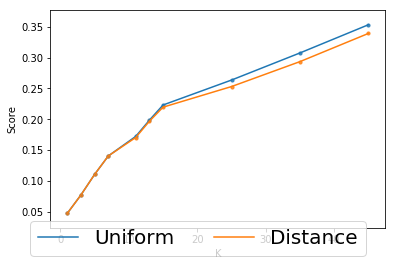

In [11]:
# #########################################################################
# #########################################################################
# ###################          Q°2E    Cancer             #################
# #########################################################################
# #########################################################################

# TODO Q2E
# Testez un classifeur K plus proches voisins sur Breast Cancer
# L'évaluation doit être faite en utilisant une approche leave-one-out
# Testez avec k = {1, 3, 5, 7, 11, 13, 15, 25, 35, 45} et avec les valeurs
# "uniform" et "distance" comme valeur de l'argument "weights".
# N'oubliez pas de normaliser le jeu de données en utilisant minmax_scale!
#
# Stockez les performances obtenues
# (précision moyenne pour chaque valeur de k)
# dans deux listes, scoresUniformWeights pour weights=uniform et
# scoresDistanceWeights pour weights=distance
# Le premier élément de chacune de ces listes devrait contenir la précision
# pour k=1, le second la précision pour k=3, et ainsi de suite.
data = load_breast_cancer()
X, y = minmax_scale(data.data, feature_range=(0, 1)), data.target

K = [1, 3, 5, 7, 11, 13, 15, 25, 35, 45]
scoresUniformWeights = []
scoresDistanceWeights = []
avgErrUni = 0
avgErrDist = 0
loo = LeaveOneOut()

KnnUni = map(lambda k: KNeighborsClassifier(n_neighbors=k,
                                            weights='uniform'), K)
KnnDist = map(lambda k: KNeighborsClassifier(n_neighbors=k,
                                             weights='distance'), K)

for Kuni, Kdist in zip(list(KnnUni), list(KnnDist)):
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        Kuni.fit(X_train, y_train)
        Kdist.fit(X_train, y_train)

        avgErrUni += 1-Kuni.score(X_test, y_test)
        avgErrDist += 1-Kdist.score(X_test, y_test)
    scoresUniformWeights.append(avgErrUni / loo.get_n_splits(X))
    scoresDistanceWeights.append(avgErrDist / loo.get_n_splits(X))


# TODO Q2E
# Produisez un graphique contenant deux courbes, l'une pour weights=uniform
# et l'autre pour weights=distance. L'axe x de la figure doit être
# le nombre de voisins et l'axe y la performance en leave-one-out
fig, sfig = plt.subplots(1, 1, sharex=True, sharey=True)
sfig.scatter(K, scoresUniformWeights, alpha=0.8, s=10)
sfig.plot(K, scoresUniformWeights)
sfig.scatter(K, scoresDistanceWeights, alpha=0.8, s=10)
sfig.plot(K, scoresDistanceWeights)
sfig.set_xlabel("K")
sfig.set_ylabel("Score")
fig.legend(("Uniform", "Distance"),
           loc="lower center", ncol=2, fontsize=20)

plt.show()

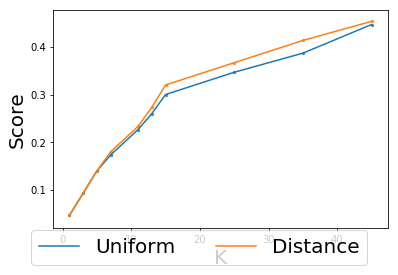

In [10]:
# #########################################################################
# #########################################################################
# ###################          Q°2D    Iris               #################
# #########################################################################
# #########################################################################
# TODO Q2E
# Testez un classifeur K plus proches voisins sur Iris
# L'évaluation doit être faite en utilisant une approche leave-one-out
# Testez avec k = {1, 3, 5, 7, 11, 13, 15, 25, 35, 45} et avec les valeurs
# "uniform" et "distance" comme valeur de l'argument "weights".
# N'oubliez pas de normaliser le jeu de données en utilisant minmax_scale!
#
# Stockez les performances obtenues
# (précision moyenne pour chaque valeur de k)
# dans deux listes, scoresUniformWeights pour weights=uniform et
# scoresDistanceWeights pour weights=distance
# Le premier élément de chacune de ces listes devrait contenir la précision
# pour k=1, le second la précision pour k=3, et ainsi de suite.
data = load_iris()
X, y = minmax_scale(data.data, feature_range=(0, 1)), data.target

K = [1, 3, 5, 7, 11, 13, 15, 25, 35, 45]
scoresUniformWeights = []
scoresDistanceWeights = []
avgErrUni = 0
avgErrDist = 0
loo = LeaveOneOut()

KnnUni = map(lambda k: KNeighborsClassifier(n_neighbors=k,
                                            weights='uniform'), K)
KnnDist = map(lambda k: KNeighborsClassifier(n_neighbors=k,
                                             weights='distance'), K)

for Kuni, Kdist in zip(list(KnnUni), list(KnnDist)):
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        Kuni.fit(X_train, y_train)
        Kdist.fit(X_train, y_train)

        avgErrUni += 1-Kuni.score(X_test, y_test)
        avgErrDist += 1-Kdist.score(X_test, y_test)
    scoresUniformWeights.append(avgErrUni / loo.get_n_splits(X))
    scoresDistanceWeights.append(avgErrDist / loo.get_n_splits(X))


# TODO Q2E
# Produisez un graphique contenant deux courbes, l'une pour weights=uniform
# et l'autre pour weights=distance. L'axe x de la figure doit être le
# nombre de voisins et l'axe y la performance en leave-one-out
fig, sfig = plt.subplots(1, 1, sharex=True, sharey=True)
sfig.scatter(K, scoresUniformWeights, alpha=0.8, s=5)
sfig.plot(K, scoresUniformWeights)
sfig.scatter(K, scoresDistanceWeights, alpha=0.8, s=5)
sfig.plot(K, scoresDistanceWeights)
sfig.set_xlabel("K", fontsize=20)
sfig.set_ylabel("Score", fontsize=20)
fig.legend(("Uniform", "Distance"),
           loc="lower center", ncol=2, fontsize=20)
plt.show()

# N'écrivez pas de code à  partir de cet endroit